In [ ]:
import pandas as pd
import numpy as np
import jellyfish
import zipfile
%matplotlib inline

##################################################################################################################
####  CODE TO NORMALIZE MANUFACTURER NAME AND CREATE UNIQUE PART NUMBERS
##################################################################################################################
def sdx(word):
    norm = jellyfish.soundex(word)
    return norm

def NormalizedManufacturer(DFrame, ManufacturerColumnName, UOMColumnName, ManufacturerCatalogColumn):    
    #Create the soundex value for each manufacturer name
    DFrame[ManufacturerColumnName] = DFrame[ManufacturerColumnName].astype('str')
    DFrame['Normalized Mfgr'] = DFrame[ManufacturerColumnName].apply(sdx)


    #Create a new column and fill it with the normalized part name.  I use the '\' for readability of code
    DFrame['UniqueID'] = DFrame[['Normalized Mfgr', 
                                 ManufacturerCatalogColumn, 
                                 UOMColumnName]].astype('str').apply(lambda x: '|'.join(x), axis=1)


    
    return DFrame

##################################################################################################################
####  CODE TO IMPORT CATALOG PRICING
##################################################################################################################

def PullCatalogs(Path):
    allFiles = glob.glob(Path + "/*.txt")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        print("Reading in '{0}'".format(file_))
        df = pd.read_table(file_, index_col=None, header=0, low_memory=False, encoding='iso-8859-1')
        list_.append(df)
        frame = pd.concat(list_)
    return frame

##################################################################################################################
####  PULL DATA FUNCTION WHICH EXTRACTS THE DATA AND CONSOLIDATES IT
##################################################################################################################
def PullData(FolderPath,FileList,OutputLocation,FileType):
    
    #for file in directory
    for fileArchive in FileList:
        #Set the zip file object
        zf = zipfile.ZipFile(FolderPath + fileArchive, 'r')

        if FileType == 'PO':
            
            #Set the filename by testing the path to see if PO or Invoice are in the path
            filename = 'POData_' + fileArchive[:-3] + 'csv'
        
            headerName = 'POHeaderCustomData_' + fileArchive[:-3] + 'csv'
        
            #Try to call the archive and pull the data from the from the archive 
            try:         
                Data = Data.append(pd.read_csv(zf.open(filename), low_memory=False, thousands=',', 
                                               parse_dates=True, encoding='iso-8859-1'),ignore_index=True)

                print('%s appended to POData' %filename)
                
                HeaderData = HeaderData.append(pd.read_csv(zf.open(headerName), low_memory=False, thousands=',', 
                                               parse_dates=True, encoding='iso-8859-1'),ignore_index=True)
                print('%s appended to Header Data' %headerName)
                

            except:
                #Try to use the data as a seed for a new DataFrame
                try:
                    Data = pd.read_csv(zf.open(filename), low_memory=False, thousands=',', parse_dates=True, encoding='iso-8859-1')
                    print('%s used to seed the Data' %filename)
                    
                    HeaderData = pd.read_csv(zf.open(headerName), low_memory=False, thousands=',', 
                                               parse_dates=True, encoding='iso-8859-1')
                
                    print('%s used to seed the Header Data' %headerName)

                #conclude the file doesnt exist
                except:
                    print('%s doesnt have a Data file' %fileArchive)

            else:
                pass
        
    Data['File'] = FolderPath + fileArchive
    
    return [Data, HeaderData]

##################################################################################################################
####  FIX THE UOM
##################################################################################################################

def UOMFix(DataFrame, UOMColumn):
    Pack =['PACK', 'PK', 'PACKAGE']
    Case =['CASE','CS','STACK','UOS','PKS','RACKS','RK','TRAY','UNI','INSERTS','CA']
    Bag = ['BAG','BG']
    Box = ['BOX','BX']
    Each= ['UNIT','BOTTLE','EACH','EA','RACK','KIT','TUBES','PIECES','REFILLS','ROLL']
    
    DataFrame[UOMColumn] = DataFrame[UOMColumn].str.replace('.*('+ '|'.join(Pack) +')$','PK', case=False) \
                                               .str.replace('.*('+ '|'.join(Case)+')$','CA', case=False) \
                                               .str.replace('.*('+ '|'.join(Bag) +')$','BG', case=False) \
                                               .str.replace('.*('+ '|'.join(Box) +')$','BX', case=False) \
                                               .str.replace('.*('+ '|'.join(Each) +')$','EA', case=False)
    return DataFrame             


##################################################################################################################
####  FUNCTION TO COUNT DISTINCT 
##################################################################################################################

def UniqueCount(x):
    return len(x.unique())

In [2]:
#Path to the files you are looking to import
path = 'C:/Users/aclark/Box Sync/BearBuy Content/Spend/'

files = ['December2016January2017PO.zip',
         'OctoberNovember2016.zip',
         'FebruaryMarch2017PO.zip',
         'September2016.zip',
         'May2017PO.zip',
         'June2017PO.zip',
         'April2017PO.zip',
         'July2017PO.zip',
         'August2017PO.zip'
        ]
output = 'x'

#Read in the data from the Full Download Zip Files
print('Reading in the Spend Data')
DataSet, HeaderSet = PullData(path,files,output,FileType='PO')

#Normalize the UOM
print()
print('Standardizing the Unit of Measures')
DataSet = UOMFix(DataSet, 'Amount/UOM & UOM')

#Establish the UniqueID for each item
print()
print('Setting Normalized Manufacturer Part Number')
DataSet = NormalizedManufacturer(DataSet, 'Manufacturer', 'Amount/UOM & UOM', 'Mfr Catalog #')

print()
print('Spend file is done')


Reading in the Spend Data
POData_December2016January2017PO.csv used to seed the Data
POHeaderCustomData_December2016January2017PO.csv used to seed the Header Data
POData_OctoberNovember2016.csv appended to POData
POHeaderCustomData_OctoberNovember2016.csv appended to Header Data
POData_FebruaryMarch2017PO.csv appended to POData
POHeaderCustomData_FebruaryMarch2017PO.csv appended to Header Data
POData_September2016.csv appended to POData
POHeaderCustomData_September2016.csv appended to Header Data
POData_May2017PO.csv appended to POData
POHeaderCustomData_May2017PO.csv appended to Header Data
POData_June2017PO.csv appended to POData
POHeaderCustomData_June2017PO.csv appended to Header Data
POData_April2017PO.csv appended to POData
POHeaderCustomData_April2017PO.csv appended to Header Data
POData_July2017PO.csv appended to POData
POHeaderCustomData_July2017PO.csv appended to Header Data
POData_August2017PO.csv appended to POData
POHeaderCustomData_August2017PO.csv appended to Header Data

In [34]:
#Unstack the headerset data to a tabular format
HeaderPivot = HeaderSet.pivot_table(index='PO ID', values='Header CF Value', columns='CF Name', aggfunc='first').fillna(0)

#merge the headerset data with the SpendData  This helps filter later
DataHeaderSet = DataSet.merge(HeaderPivot, how='left', left_on='PO ID', right_index=True)

#Filter the DataSet to just the information we are looking for.  Potential fields are below and commented out
#Procurement Dept Code
#Department ID
#Fund

#Limit to Procurment Dept Code = 30**** and fund 5011
#TargetData = DataHeaderSet[(DataHeaderSet['Procurement Dept Code'].str.startswith('30', na=False)) & 
#              (DataHeaderSet['Fund'] == '5011') ]

SODDeptIDs = {'301008':'D_Pediatric Dentistry Clinics',
              '301011':'D_Craniofacial Clinic',
              '301014':'D_Orthodontic Clinic',
              '301017':'D_Oral Pathology Clinic',
              '301020':'D_Periodontology Clinic',
              '301023':'D_Oral Medicine Clinic',
              '302046':'D_Orofacial Pain',
              '302047':'D_Hospital Dentistry and GPR',
              '302048':'D_Oral and Maxillofacial Surg',
              '302049':'D_OMFS-ZSFG',
              '303050':'D_Billing',
              '303053':'D_Central Supply',
              '303055':'D_Sterilization',
              '303056':'D_Oral Radiology',
              '303057':'D_Mechanicians',
              '303051':'D_Student Clinic',
              '303054':'D_Labs',
              '303058':'D_Dispensary',
              '303059':'D_Buchanan',
              '303073':'D_Student Kit',
              '303074':'D_IDP Kit',
              '303072':'D_Fleming Lab',
              '305067':'D_Adv Educ General Dentistry',
              '305069':'D_Faculty Group Practice',
              '305072':'D_Grad Pros',
              '305073':'D_UC Pros',
              '305075':'D_Post Grad Endo',
              '305076':'D_Faculty Endo'}
              
TargetData = DataHeaderSet[(DataHeaderSet['Department ID'].str.startswith('30', na=False)) & 
                           (DataHeaderSet['Department ID'].isin(SODDeptIDs.keys()))] 

TargetData = TargetData.replace({'Department ID': SODDeptIDs})

In [140]:
#Find the top X suppliers per department
A = TargetData.groupby(['Department ID','Supplier Name']).agg({'Extended Price': 'sum'}).sort_values('Extended Price',ascending=[0])
A.groupby(level=0, group_keys=False).apply(lambda x: x.nlargest(5, ['Extended Price'])).to_csv('C:/users/aclark/desktop/topsupplier.csv')

B = TargetData[TargetData['Normalized Mfgr'] != 'n500'].groupby(['Department ID','Normalized Mfgr']).agg({'Extended Price': 'sum'}).sort_values('Extended Price',ascending=[0])
B = B.groupby(level=0, group_keys=False).apply(lambda x: x.nlargest(5, ['Extended Price']))

#Create Map of Normalized MFR to Mfr Name
C = TargetData[TargetData['Normalized Mfgr'] != 'n500'].groupby(['Normalized Mfgr','Manufacturer']).agg({'Extended Price': 'sum'}).sort_values('Extended Price',ascending=[0])
C = C.groupby(level=0, group_keys=False).apply(lambda x: x.nlargest(1, ['Extended Price'])).reset_index()
C = pd.Series(TargetData['Manufacturer'].values,index=TargetData['Normalized Mfgr']).to_dict()

B = B.reset_index().replace({'Normalized Mfgr': D}).set_index(['Department ID','Normalized Mfgr']).to_csv('C:/users/aclark/desktop/topmfr.csv')

### Advanced Analytics

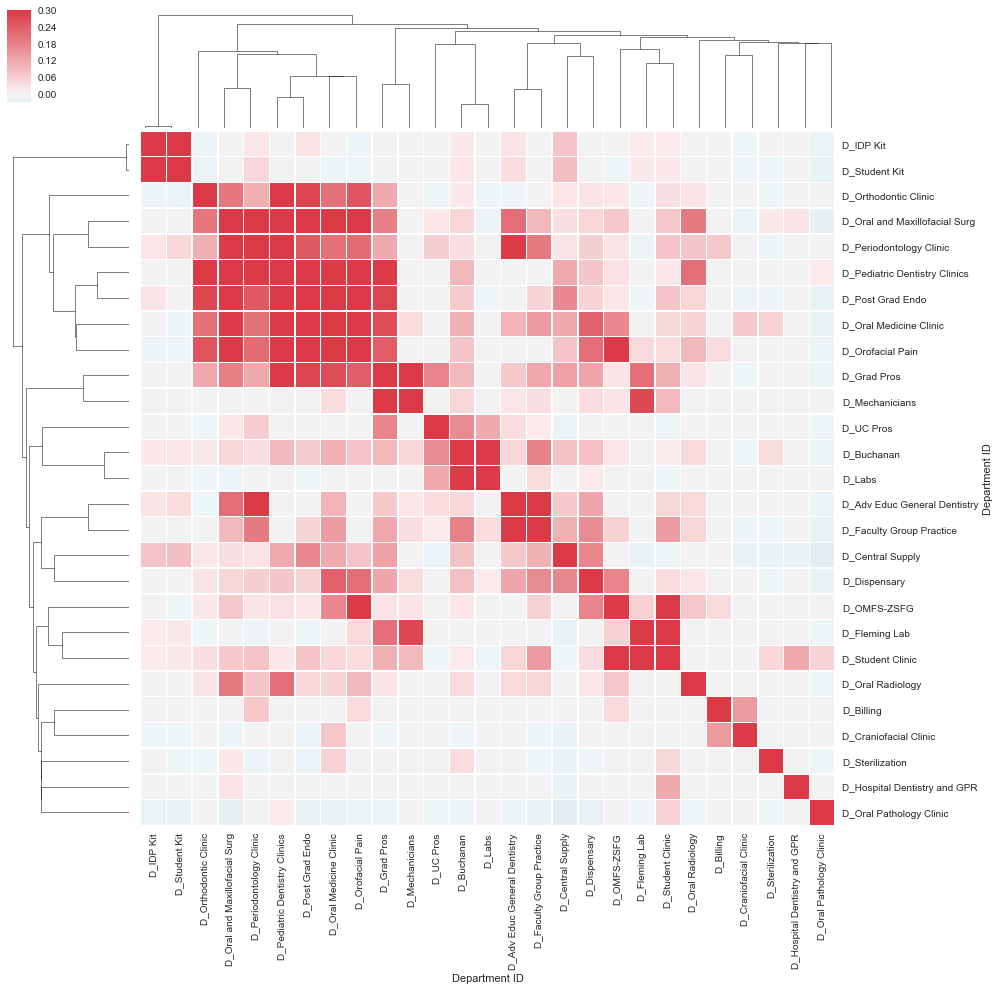

In [99]:
#Correlation of Suppliers

import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt

#Data
#Create the intersection of suppliers and funds 
d = TargetData.pivot_table(index='Supplier Name',
                       columns='Department ID', 
                       values='Extended Price', 
                       aggfunc='sum').fillna(0)

#Heat map
sns.set(style="white")

# Compute the correlation matrix
corr = d.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.clustermap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, figsize=(15,15)).savefig('C:/Users/aclark/Desktop/ClusterMap.png')


In [138]:
B

Extended Price
Department ID                Normalized Mfgr                                    
D_Adv Educ General Dentistry Henry Schein Inc.                           2987.10
                             James Standfield Catering                   2574.40
                             GC America, Inc.                            1947.90
                             Belkin Cables Only                          1308.00
                             Dentsply Rinn                               1223.25
D_Billing                    HEWLETT PACKARD COMPANY                     1857.85
                             FUJITSU SCANNER PRODUCTS                     455.15
                             HUMANSCALE                                   414.74
                             Georgia-Pacific                              382.14
                             ROYAL SOVEREIGN INTERNATIONAL                209.88
D_Buchanan                   James Standfield Catering                   7531.80
                             HEWLETT PACKARD COMPANY                     3230.74
                             Cybelle`s Front Room                        3157.50
                             Dell                                        2112.12
                             Topaz Systems                               1916.72
D_Central Supply             Danville Materials, Inc                     8052.98
                             Tidi Products LLC                           5549.40
                             Dentsply Rinn                               4324.32
                             Fisher Scientific                           3515.34
                             Baxter Healthcare                           2954.16
D_Craniofacial Clinic        SHARP ELECTRONICS USE V#                    4461.76
                             Invitrogen                                  1166.52
                             QIAGEN                                       729.00
                             New England Biolabs Inc (NEB)                672.80
                             Patxi`s Pizza Catering Inner Sunset          504.00
D_Dispensary                 Kerr Corporation                            1189.40
                             HP Inc Supplies                              851.09
                             HEWLETT PACKARD COMPANY                      635.09
                             Bosworth Co                                  470.12
                             Gingi-Pak Pharmaceutical                     397.68
...                                                                          ...
D_Periodontology Clinic      Millipore                                   5681.50
                             SIGMA-ALDRICH                               1262.05
                             Dell                                        1250.06
                             HEWLETT PACKARD COMPANY                     1219.06
                             Ladle and Leaf Catering                     1209.52
D_Post Grad Endo             Dell                                        1091.98
                             La Mediterranee                              778.84
                             FUJITSU SCANNER PRODUCTS                     487.84
                             Canon                                        405.37
                             Ladle and Leaf Catering                      351.26
D_Sterilization              Dell                                         555.68
                             COMPX NATIONAL                               353.80
                             DUX Dental VanR Cadco Clive                  294.50
                             ALPHA PROTECH                                247.20
                             Canon                                         95.95
D_Student Clinic             Dell                                       60253.85
                             James Standfield Catering                  13213.10
                